In [1]:
from icecube import dataclasses, dataio, icetray
from icecube.icetray import I3Units
import numpy as np
from scipy.stats import bootstrap
import csv
import matplotlib.pyplot as plt

In [2]:
def get_length_energy(file, clsim=False, before_pruning=False, my_sim=False):
    infile=dataio.I3File(file)

    track_length = []
    energy = []
    while(infile.more()):
        #print(frame_count)
        frame = infile.pop_daq()
        if clsim:
            mctree = frame["I3MCTree_clsim"]
        elif before_pruning:
            mctree = frame["I3MCTree_before_PROPOSAL_pruning"]
        elif my_sim:
            mctree = frame["I3MCTree_katil"]
        else:
            mctree = frame["I3MCTree"]
        mcTreeprimary = mctree.primaries
        track_length.append(mcTreeprimary[0].length)
        energy.append(mcTreeprimary[0].energy)
        
    return np.array(track_length), np.array(energy)

In [3]:
track_length_GEANT4, energy_GEANT4 = get_length_energy('../I3Files/oscNext_bare_lepton_toy_step2_pass2.139003.000000.i3.zst', clsim=True, before_pruning=False)

In [4]:
track_length_original, energy_original = get_length_energy('../I3Files/illume/oscNext_bare_lepton_toy_step2_pass2_katil.139003.000000.i3.zst', my_sim=True)

In [5]:
track_length_vcut_005, energy_vcut_005 = get_length_energy('../I3Files/illume/oscNext_bare_lepton_toy_step2_pass2_katil_vcut005.139003.000000.i3.zst', my_sim=True)

In [6]:
track_length_vcut_001, energy_vcut_001 = get_length_energy('../I3Files/illume/oscNext_bare_lepton_toy_step2_pass2_katil_vcut001.139003.000000.i3.zst', my_sim=True)

In [7]:
track_length_vcut_0001, energy_vcut_0001 = get_length_energy('../I3Files/illume/oscNext_bare_lepton_toy_step2_pass2_katil_vcut0001.139003.000000.i3.zst', my_sim=True)

In [8]:
track_length_vcut_00001, energy_vcut_00001 = get_length_energy('../I3Files/illume/oscNext_bare_lepton_toy_step2_pass2_katil_vcut00001.139003.000000.i3.zst', my_sim=True)

In [9]:
def median_bootstrap(data):
    data = (data,)
    #calculate 95% bootstrapped confidence interval for median
    bootstrap_se = bootstrap(data, np.median, confidence_level=0.95,
                             random_state=1, method='percentile')
    return bootstrap_se.standard_error

def uncerainity_prop_div(P, Q, R):
    '''
    Calculating the error in the ratio (ratio_err = (A/B)*np.sqrt((A_err/A)**2+(B_err/B)**2))
    ratio_err = P*np.sqrt(Q**2 + R**2)
    '''
    return P*np.sqrt(Q**2 + R**2)

In [10]:
def get_avg_ratio(track_length, track_length_GEANT4, energy, energy_GEANT4):
    energy_range = np.arange(1, 100, 1)
    
    mean_ratio = []
    err = []
    err_PROPOSAL = []
    
    for i in energy_range:
        mask = (energy >= i) & (energy < i+1)
        mask_GEANT4 = (energy_GEANT4 >= i) & (energy_GEANT4 < i+1)
        GEANT4 = track_length_GEANT4[mask_GEANT4]
        PROPOSAL = track_length[mask]
        
        ratio = np.median(GEANT4)/np.median(PROPOSAL)
        ratio1 = np.median(PROPOSAL)/np.median(PROPOSAL)
        
        GEANT4_err = median_bootstrap(GEANT4)
        PROPOSAL_err = median_bootstrap(PROPOSAL)
        
        #P = ratio
        #Q = GEANT4_err/np.median(GEANT4)
        #R = PROPOSAL_err/np.median(PROPOSAL)
        
        ratio_err = uncerainity_prop_div(ratio, GEANT4_err/np.median(GEANT4), PROPOSAL_err/np.median(PROPOSAL))
        ratio1_err = uncerainity_prop_div(ratio, PROPOSAL_err/np.median(PROPOSAL), PROPOSAL_err/np.median(PROPOSAL))
        
        mean_ratio.append(ratio)
        err.append(ratio_err)
        err_PROPOSAL.append(ratio1_err)
        
    return np.array(mean_ratio), np.array(err), np.array(err_PROPOSAL), energy_range

In [11]:
mean_ratio_GEANT4, standard_err_GEANT4, proposal_err_GEANT4, energy_range = get_avg_ratio(track_length_GEANT4, track_length_GEANT4, energy_GEANT4, energy_GEANT4)
mean_ratio_original, standard_err_original, proposal_err_original, energy_range = get_avg_ratio(track_length_original, track_length_GEANT4, energy_original, energy_GEANT4)
mean_ratio_vcut_005, standard_err_vcut_005, proposal_err_vcut_005, energy_range = get_avg_ratio(track_length_vcut_005, track_length_GEANT4, energy_vcut_005, energy_GEANT4)
mean_ratio_vcut_001, standard_err_vcut_001, proposal_err_vcut_001, energy_range = get_avg_ratio(track_length_vcut_001, track_length_GEANT4, energy_vcut_001, energy_GEANT4)
mean_ratio_vcut_0001, standard_err_vcut_0001, proposal_err_vcut_0001, energy_range = get_avg_ratio(track_length_vcut_0001, track_length_GEANT4, energy_vcut_0001, energy_GEANT4)
mean_ratio_vcut_00001, standard_err_vcut_00001, proposal_err_vcut_00001, energy_range = get_avg_ratio(track_length_vcut_00001, track_length_GEANT4, energy_vcut_00001, energy_GEANT4)

In [12]:
def plot_ratio(energy_range, median, standard_error, proposal_error, title):
    plt.figure(figsize=(17, 2))
    plt.errorbar(energy_range, median, yerr=standard_error, linewidth=3, fmt='o-', label='GEANT4')
    plt.axhline(1, c='r', linewidth=3, label='PROPOSAL')
    plt.fill_between(energy_range, 1-proposal_error, 1+proposal_error, facecolor='pink', alpha=.6)
    plt.title(title)
    plt.xlabel('Energy[GeV]')
    plt.ylabel('Track Length Ratio')
    #plt.ylim(0.9, 1.1)
    plt.legend()
    plt.show()

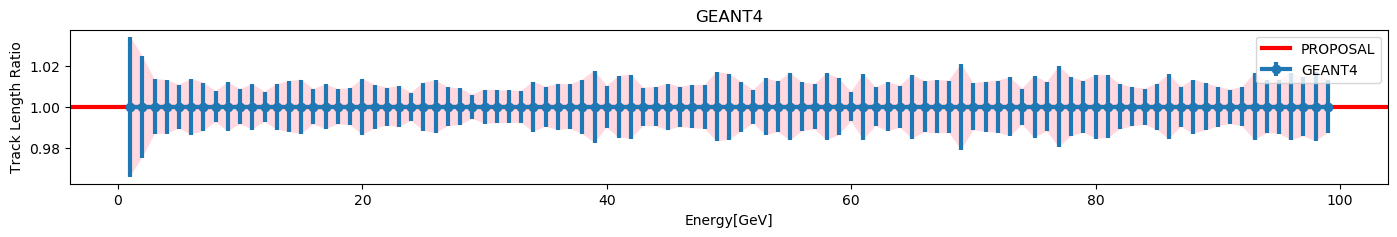

In [13]:
plot_ratio(energy_range, mean_ratio_GEANT4, standard_err_GEANT4, proposal_err_GEANT4, 'GEANT4')

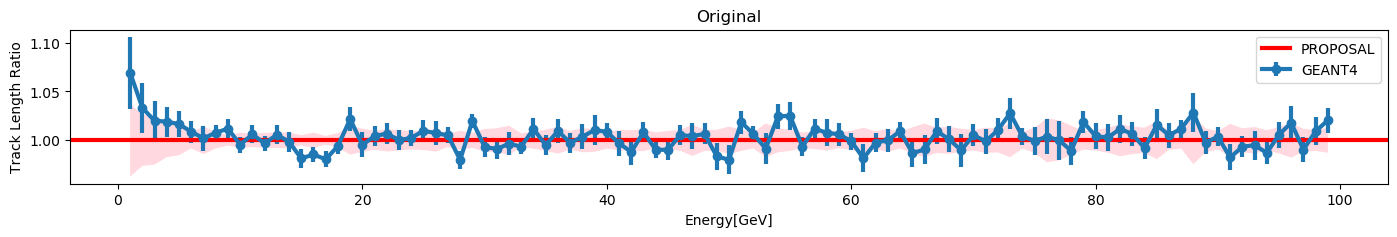

In [14]:
plot_ratio(energy_range, mean_ratio_original, standard_err_original, proposal_err_original, 'Original')

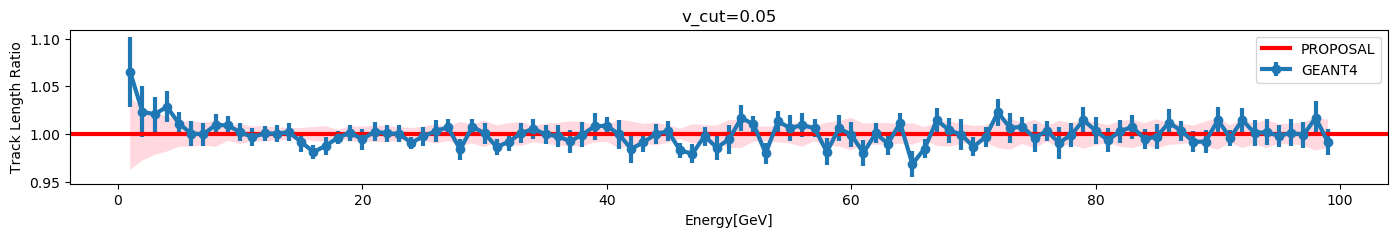

In [15]:
plot_ratio(energy_range, mean_ratio_vcut_005, standard_err_vcut_005, proposal_err_vcut_005, 'v_cut=0.05')

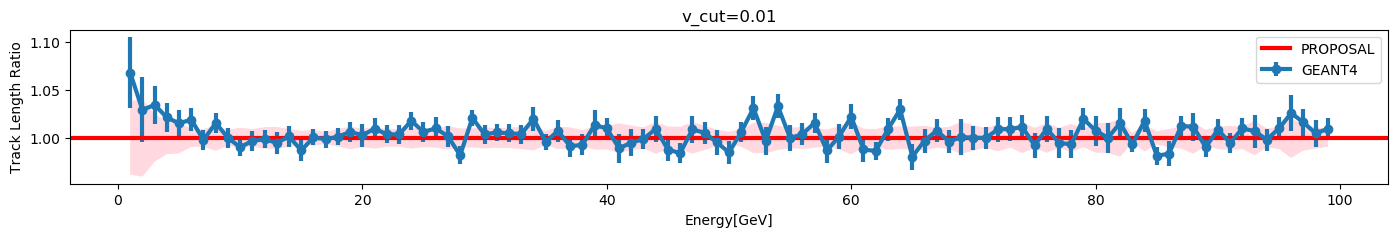

In [16]:
plot_ratio(energy_range, mean_ratio_vcut_001, standard_err_vcut_001, proposal_err_vcut_001, 'v_cut=0.01')

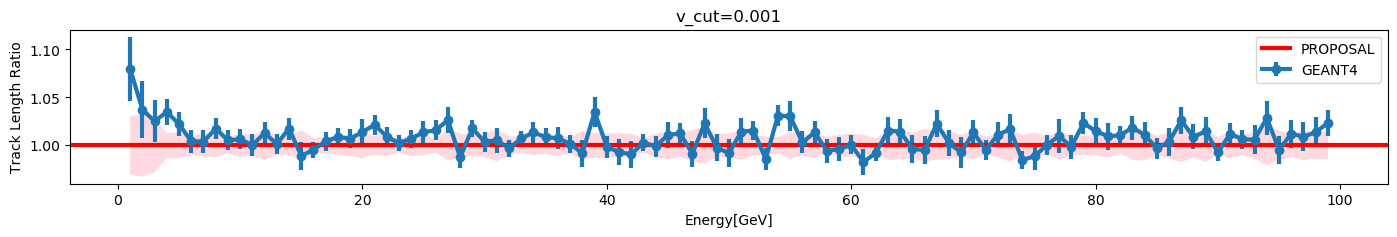

In [17]:
plot_ratio(energy_range, mean_ratio_vcut_0001, standard_err_vcut_0001, proposal_err_vcut_0001, 'v_cut=0.001')

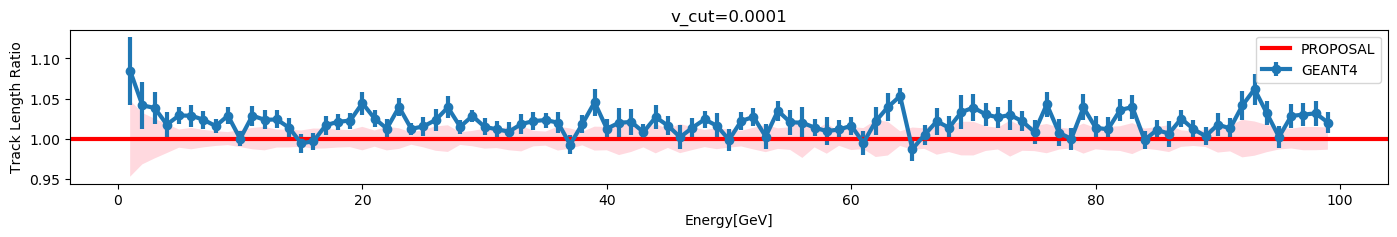

In [18]:
plot_ratio(energy_range, mean_ratio_vcut_00001, standard_err_vcut_00001, proposal_err_vcut_00001, 'v_cut=0.0001')

In [46]:
print(mean_ratio_original.max())
print(mean_ratio_vcut_005.max())
print(mean_ratio_vcut_001.max())
print(mean_ratio_vcut_0001.max())
print(mean_ratio_vcut_00001.max())

1.0692057077793102
1.065017256237196
1.068293489223853
1.0796116894105519
1.0845873124315377


In [50]:
print(mean_ratio_original.max())
print(mean_ratio_vcut_005.max())
print(mean_ratio_vcut_001.max())
print(mean_ratio_vcut_0001.max())
print(mean_ratio_vcut_00001.max())

1.0692057077793102
1.0679987992998778
1.068293489223853
1.0796116894105519
1.0845873124315377
